<a href="https://colab.research.google.com/github/Mr-Moore/machine-learning/blob/main/transformer_flowers104/03m_transformer_flowers104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.12.0


In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


Learning rate schedule: 0.0002 to 0.0002 to 1.04e-05


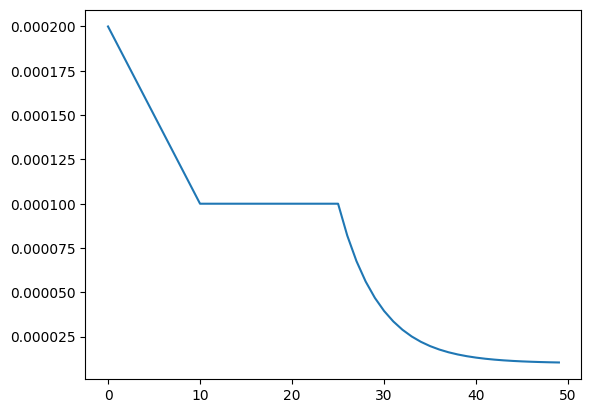

In [ ]:
GCS_DS_PATH = "gs://practical-ml-vision-book/flowers_104_tfr"

# Settings for TPUv3 / T4 with sufficient memory.
# When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [224, 224] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 50

# Learning rate schedule
LR_START = 0.0002
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 15
LR_EXP_DECAY = .8

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

# This dataset is split three ways, training, validation, test
# but we will use it split two ways only: training and validation.
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
VALIDATION_FILENAMES =  tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15000, linewidth=80000)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation,'--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum = example['id'] # image id, not used
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16465 training images, 7382 validation images


In [ ]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
Training data label examples: [67 79 75 49 65 47  4 57 64 83 73 99 75  8  4  0]


In [ ]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

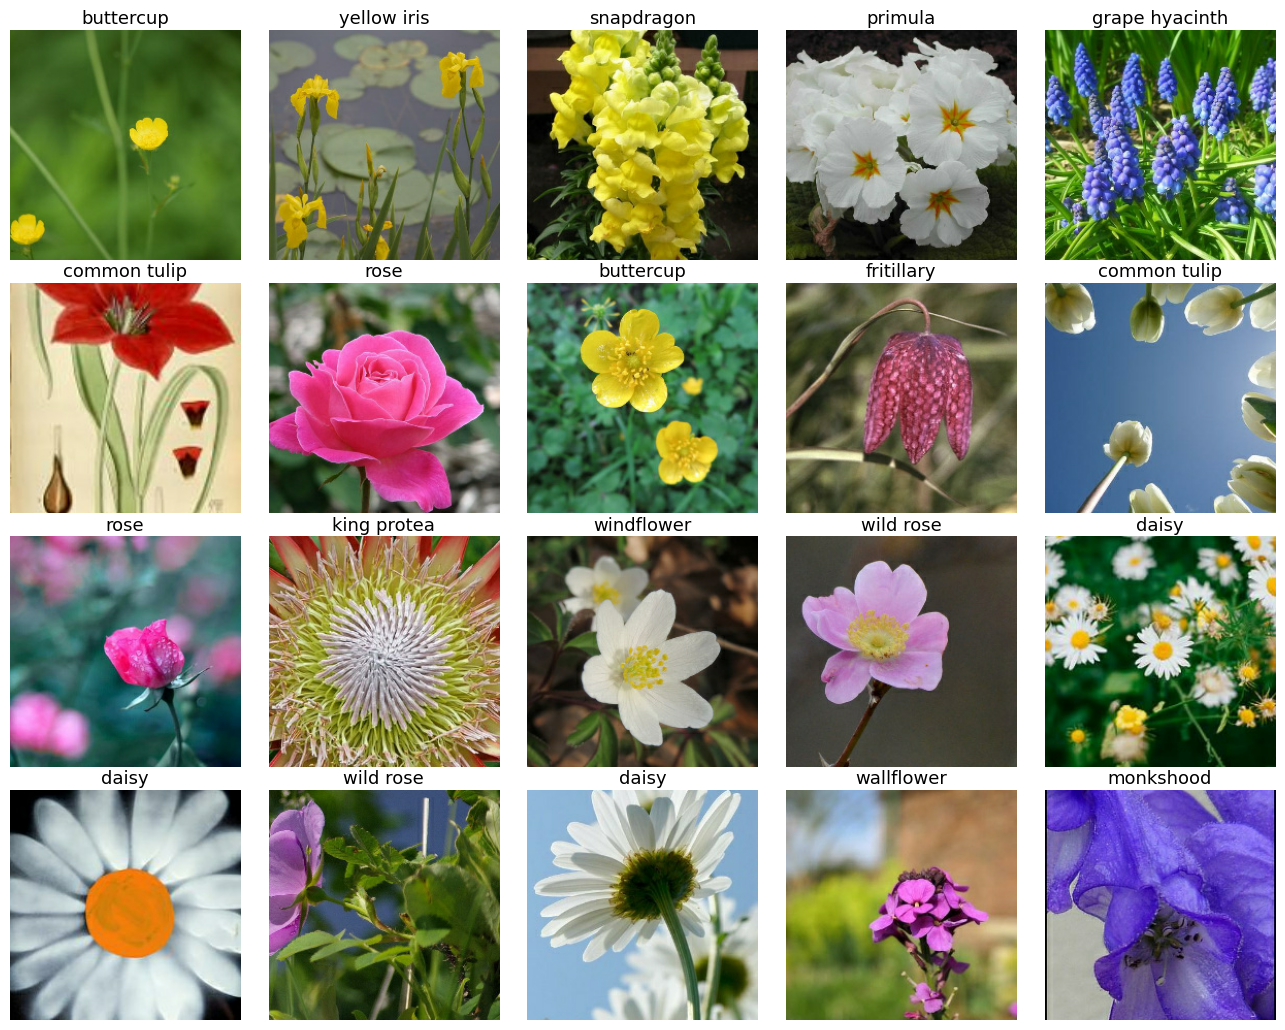

In [ ]:
# run this cell again for next set of images
x = next(train_batch)
display_batch_of_images(x)

In [ ]:
PATCH_SIZE = 16
num_patches = (IMAGE_SIZE[0] // PATCH_SIZE) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
  projection_dim * 2,
  projection_dim,
] # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier

In [ ]:
# tf.keras.layer.Layer: This is the class from which all layers inherit.(All layers inherit from this class.)
# __init__(): Defines custom layer attributes.
class Patches(tf.keras.layers.Layer):
  # init: 物件 (object) 建立時所執行的方法.
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size
    # self.tr_set = 1 (custom any attribution you want)

  def call(self, images):
    batch_size = tf.shape(images)[0]
    # https://www.tensorflow.org/api_docs/python/tf/image/extract_patches
    patches = tf.image.extract_patches(
      images=images,
      sizes=[1, self.patch_size, self.patch_size, 1],
      strides=[1, self.patch_size, self.patch_size, 1],
      rates=[1, 1, 1, 1],
      padding="VALID",
    )
    # print(self.tr_set)
    # print(np.array(patches)[0][0])
    patch_dims = patches.shape[-1]
    # print(patch_dims)
    # If one component of shape is the special value -1, the size of that dimension is computed so that the total size remains constant.
    # At most one component of shape can be -1.
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # (20, 14, 14, 768) -> (20, 196, 768)
    # print(tf.shape(patches))

    return patches

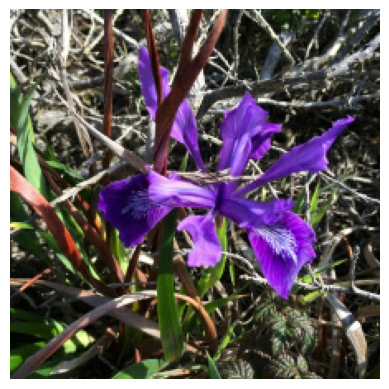

In [ ]:
# next(train_batch)[0] will be all images in this batch. So need to be next(train_batch)[0][0] to show the first image in this batch.
image = next(train_batch)[0]
plt.imshow(image[0])
plt.axis('off');
# print(image[0])

In [ ]:
x = tf.constant([[[2, 1, 2]], [[1, 3, 4]], [[4, 5 ,6]]])
print(x[0])

tf.Tensor([[2 1 2]], shape=(1, 3), dtype=int32)


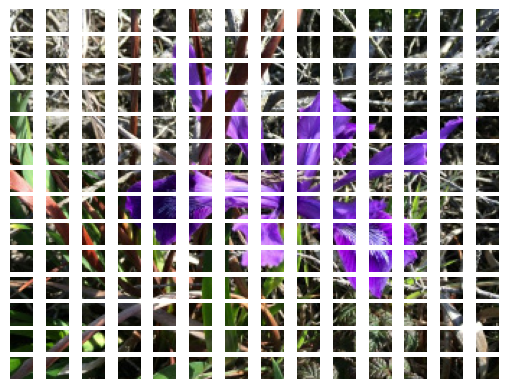

In [ ]:
# patches has [20][196][768] size.One [] minus one []. If patches[0-19] -> [[768elements],[768elements]...(196)[768elements]].
# 每一個[]就剝掉外面一層[].
patches = Patches(PATCH_SIZE)(image)
n = int(np.sqrt(patches.shape[1]))
# subplot(nrows, ncols, index, **kwargs), index starts at 1 in the upper left corner and increases to the right.
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, [PATCH_SIZE, PATCH_SIZE, 3])
  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
n = 10
# images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100
images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]
# We generate two outputs as follows:
# 1. 3x3 patches with stride length 5
# 2. Same as above, but the rate is increased to 2

tf.image.extract_patches(
  images=images,
  sizes=[1, 3, 3, 1],
  strides=[1, 5, 5, 1],
  rates=[1, 1, 1, 1],
  padding='VALID'
)

<tf.Tensor: shape=(1, 2, 2, 9), dtype=int32, numpy=
array([[[[ 1,  2,  3, 11, 12, 13, 21, 22, 23],
         [ 6,  7,  8, 16, 17, 18, 26, 27, 28]],

        [[51, 52, 53, 61, 62, 63, 71, 72, 73],
         [56, 57, 58, 66, 67, 68, 76, 77, 78]]]], dtype=int32)>

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection_dim = tf.keras.layers.Dense(units=projection_dim)
    # tf.keras.layers.Embedding: Turns positive integers (indexes) into dense vectors of fixed size.
    self.position_embedding = tf.keras.layers.Embedding(
      input_dim=num_patches, output_dim=projection_dim
    )

  # tf.range: Creates a sequence of numbers that begins at start and extends by increments of delta up to but not including limit.
  def call(self, patch):
    positions = tf.range(0, self.num_patches, delta=1)
    # Can see 03f_fromzero_SQUEEZENET24_flowers104.ipynb how to construct these kind of model.
    # using + Dimensions must be equal!!!
    encoded = self.position_embedding(positions) + self.projection_dim(patch)
    return encoded

In [ ]:
# mlp(multilayer perceptron): 由多個的節點層所組成，每一層都全連接到下一層。
# Variance是不同的训练数据集训练出的模型输出值之间的差异。
# Bias = - 閥值
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  return x
# By putting None as the dimension of the tensor you enable to keep things flexible and allow for any number of samples.
def create_vit_classifier():
  inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
  # Create patches.
  patches = Patches(PATCH_SIZE)(inputs)
  # Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the Transformer block.
  # When you are not interested in some values returned by a function we use underscore in place of variable name .
  for _ in range(transformer_layers):
    # Layer normalization 1.
    # Normalize the activations of the previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization.
    # https://medium.com/ching-i/batch-normalization-%E4%BB%8B%E7%B4%B9-135a24928f12 詳見圖示1(尺度和中心見課本P48)

    # epsilon(ε): Small float added to variance to avoid dividing by zero. Defaults to 1e-3
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create a multi-head attention layer.
    attention_output = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # Skip connection 1.
    # tf.keras.layers.Add(): A tensor as the sum of the inputs. It has the same shape as the inputs.
    x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
    # Layer normalization 2.
    x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    x3 = mlp(x3, transformer_units, 0.1)
    # Skip connection 2.
    encoded_patches = tf.keras.layers.Add()([x3, x2])

  # Create a [batch_size, projection_dim] tensor.
  # 內部如何運作如同None一樣，我認為是照他內部的程式碼去執行訓練的。Summary的參數是個大概參考。
  representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = tf.keras.layers.Flatten()(representation)
  representation = tf.keras.layers.Dropout(0.5)(representation)
  # Add MLP.
  features = mlp(representation, mlp_head_units, 0.5)
  # Classify outputs.
  logits = tf.keras.layers.Dense(len(CLASSES))(features)
  # Create the keras model.
  model = tf.keras.Model(inputs=inputs, outputs=logits)
  return model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(16,32)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.output_shape

(None, 16, 32)

In [ ]:
with strategy.scope():
  model = create_vit_classifier()

model.compile(
  optimizer='adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['sparse_categorical_accuracy'],
  steps_per_execution=8
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['input_2[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 196, 64)      61760       ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 196, 64)     128         ['patch_encoder[0][0]']      

In [ ]:
# https://keras.io/api/models/model_training_apis/
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
           validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
           callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/50
1029/1029 [==============================] - 110s 107ms/step - loss: 4.2815 - sparse_categorical_accuracy: 0.0714 - val_loss: 3.6647 - val_sparse_categorical_accuracy: 0.1315 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019.
Epoch 2/50
1029/1029 [==============================] - 61s 60ms/step - loss: 3.7988 - sparse_categorical_accuracy: 0.1067 - val_loss: 3.5305 - val_sparse_categorical_accuracy: 0.1525 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00018.
Epoch 3/50
1029/1029 [==============================] - 61s 59ms/step - loss: 3.6383 - sparse_categorical_accuracy: 0.1212 - val_loss: 3.3784 - val_sparse_categorical_accuracy: 0.1777 - lr: 1.8000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00017.
Epoch 4/50
1029/1029 [==============================] - 62s 60ms/step - loss: 3.5115 - sparse_categorical_accuracy: 0.1392 - val_los

<ipython-input-4-10f1d33019c9>:96: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


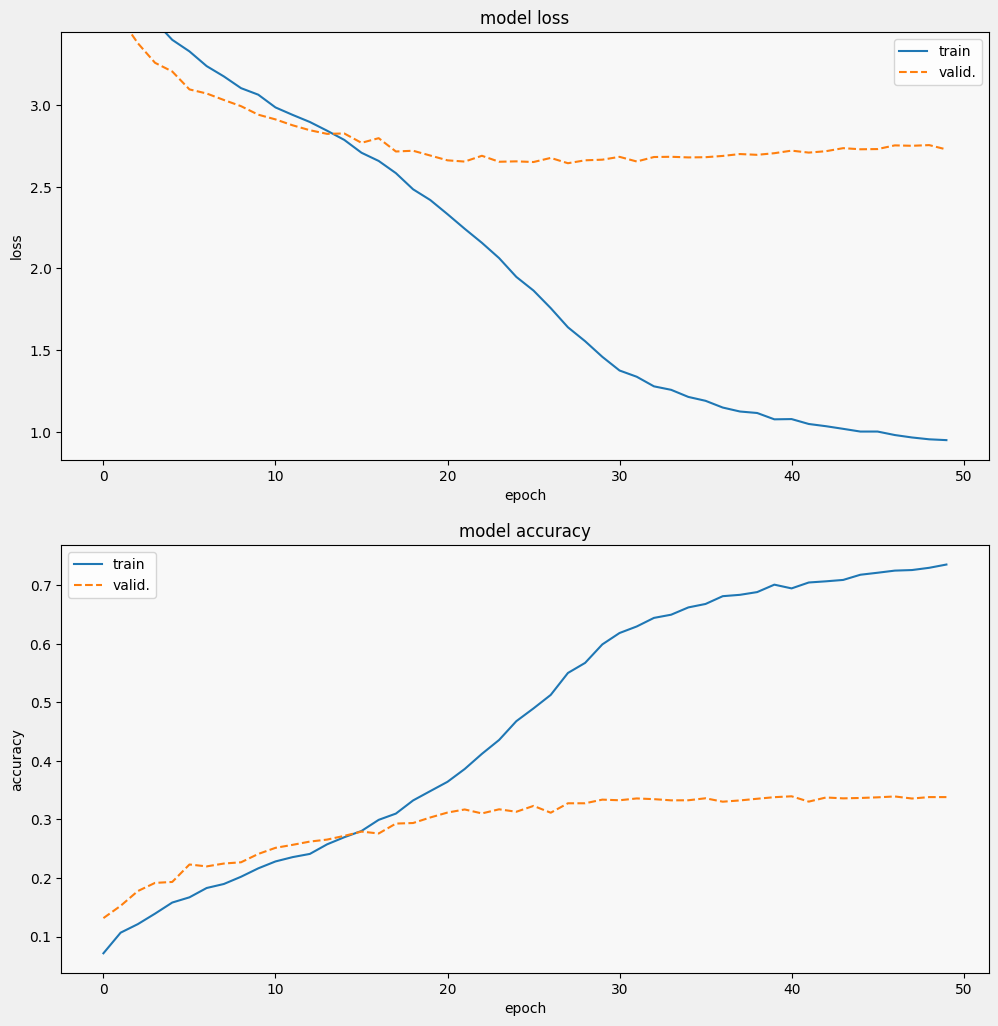

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, zoom_pcent=90)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [ ]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

462/462 [==============================] - 11s 23ms/step
Correct   labels:  (7382,) [ 67  28  52  49  81  69  67  77  95  25  69  25  68   0   4  80  43  75  65  81  63  49  67  73  46  53  70   4  13  70 103 103  13  14  73 103  75  92  53  28 103 103  49  94  82  40  57  78  77  63  49  67  40  49  77  67  81  97 103  34  71   4  56  86  74  53   0  10  43   9  74  62  18  45   4  24  48   7  86  53  50   4  59  77  13  49  69  49  67  74  80   4  72   4  93  70  73  21  69  67  13  82  67  91  14  75  90  48  41  50  91   4  94  43  46  47  29  95 102  53   4 102  67  57   2  50  67  52  59  54 100   7  13  30  78  53 103  67  94  56  25  62  73  49  67  71  62  24  53  50  10  10  73  91   0   4  73  53  73 103  73   3  64  10   7  67  11  45  67  13  49  73  49  68 103  14  25  56  53  95   4  51   4  57  24  49  22  93  67 102   7  72  47 102   0  68  12  72  68  51 103  82  99  77  64  69  13   8  75  24  77 103  49  50  67  53  67 102  96  41  56  96  43   4  67  78  13   5  80

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


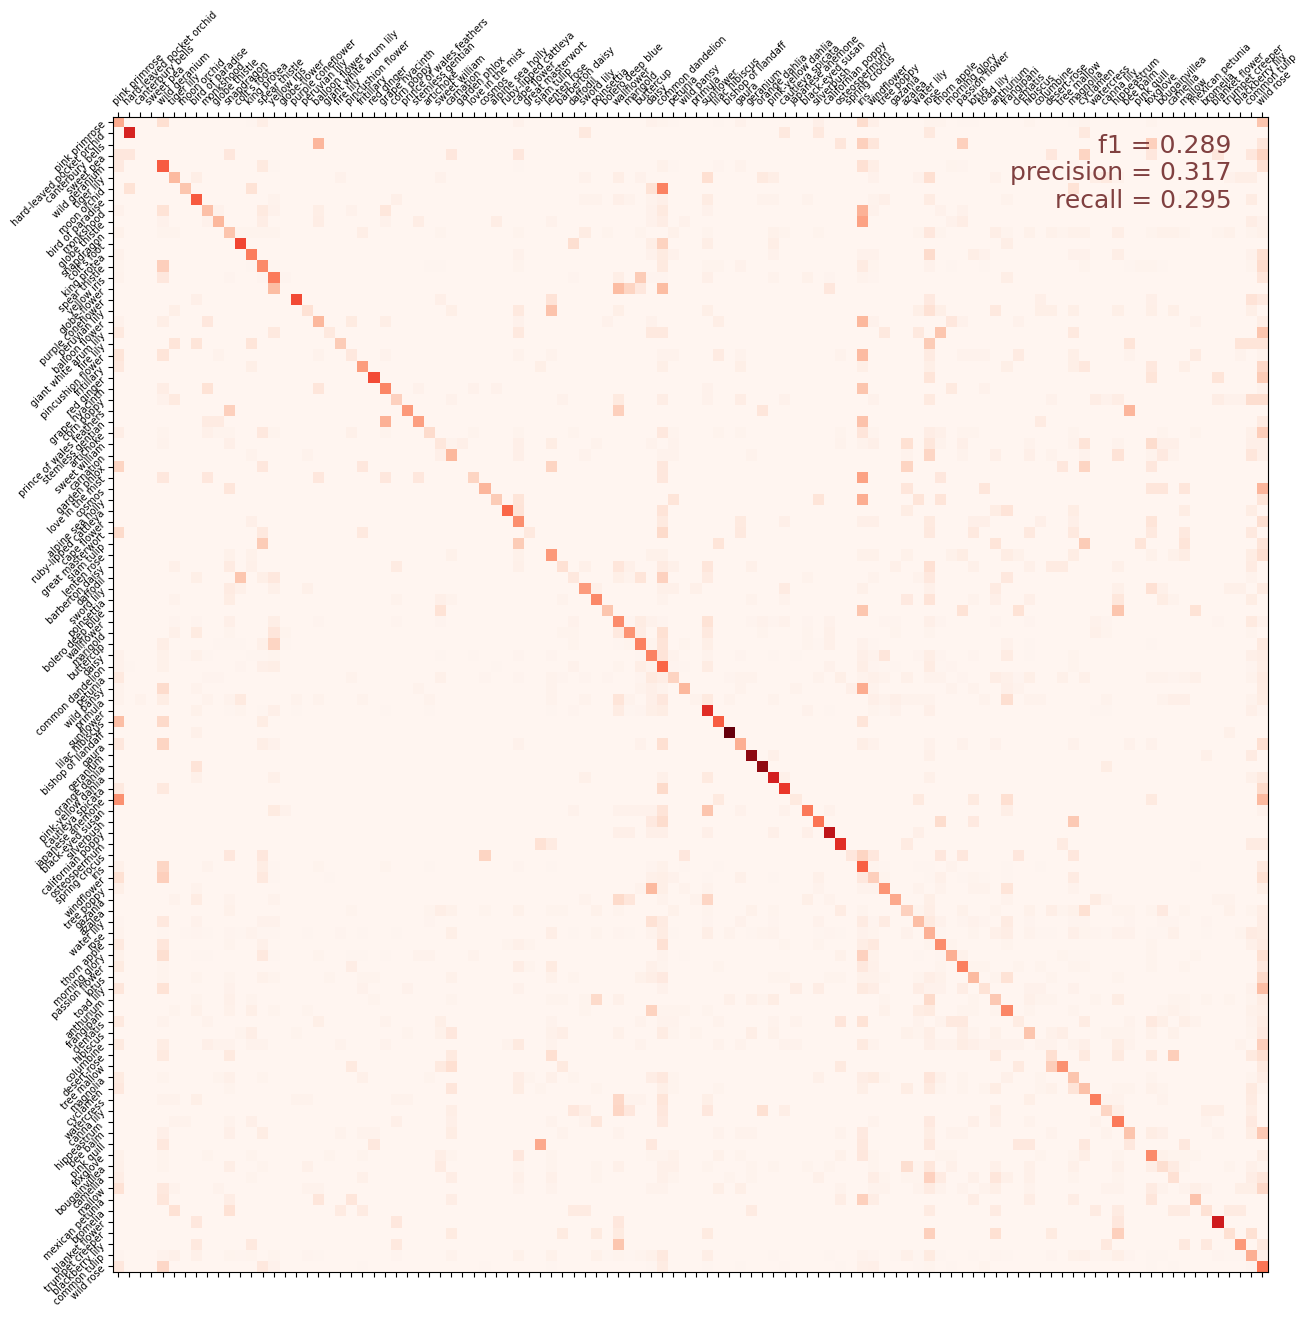

f1 score: 0.289, precision: 0.317, recall: 0.295


In [ ]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

1/1 [==============================] - 0s 117ms/step


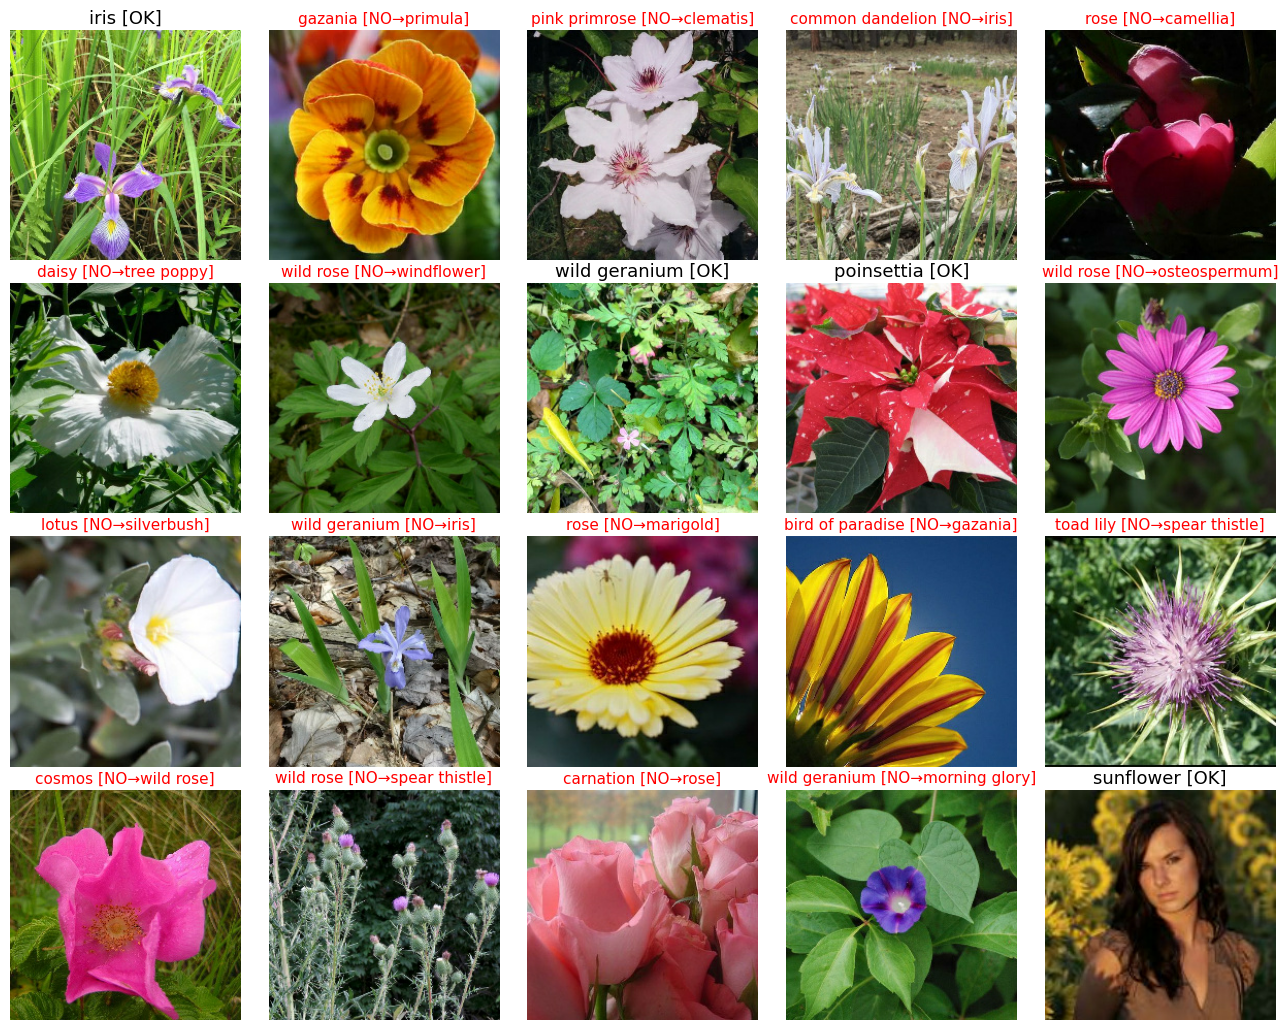

In [ ]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(1000, size=(32, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)

1/1 [==============================] - 0s 43ms/step
[[[ 0.03162818 -0.03141896  0.0003167  ... -0.03353094 -0.01705164 -0.0097326 ]
  [-0.0147854  -0.00853641  0.01574207 ...  0.00011053 -0.00606322 -0.03739832]
  [-0.03395438 -0.01529145  0.03609863 ... -0.02024788  0.02347249 -0.00771362]
  ...
  [-0.01995597  0.02974752  0.00930802 ...  0.04370618  0.02405716 -0.0075056 ]
  [ 0.04816595  0.02206935  0.01324774 ...  0.04340322  0.02369008  0.0421816 ]
  [ 0.04173135 -0.01571387  0.04876036 ... -0.00923834  0.01931358 -0.00624023]]

 [[-0.01117858 -0.04241289  0.00999457 ... -0.04436169 -0.04892044 -0.03189907]
  [ 0.035005   -0.00712919  0.01322019 ...  0.04560791  0.04132904  0.0425566 ]
  [ 0.00962546 -0.0006027  -0.04080827 ... -0.00107546  0.00500826 -0.04755777]
  ...
  [ 0.03708858  0.04319552  0.00032154 ... -0.00722872 -0.00771426 -0.03811278]
  [ 0.03655375  0.01579745 -0.02694911 ...  0.04196364 -0.02605846 -0.00067969]
  [ 0.02708039 -0.005922   -0.02809335 ... -0.00194085